<a href="https://colab.research.google.com/github/SidBthegr8/ts_tutorial/blob/minor-fixes/ts_tutorial_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Tutorial on Thompson Sampling

This colab notebook provides a way to play around with the code for [A Tutorial on Thompson Sampling](https://arxiv.org/abs/1707.02038) without needing to install anything.

All of the underlying code is taken from the public git repository:
https://github.com/iosband/ts_tutorial


## Cloning the respository and setting up the environment

Our code is made to work with Python 3.8 but would likely work with other versions.

The commands below allow the package to be run in a default Google colab kernel.

In [1]:
#@title Cloning github repository and installing requied packaged
%%capture
!git clone https://github.com/iosband/ts_tutorial.git
!pip install plotnine
!pip install cvxpy

In [35]:
# Install Microsoft core fonts (including Times New Roman)
!apt-get install -y fonts-roboto
!apt-get install -y ttf-mscorefonts-installer

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-roboto is already the newest version (2:0~20170802-3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ttf-mscorefonts-installer is already the newest version (3.8ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [14]:
#@title Code assumes you are running from `ts_tutorial/src` directory
!cd /content/ts_tutorial/src

## Reproducing specific figures

We present the exact code used to generate the figures for each plot in `reproduce_figures.py`.

If you run this script with appropriate flags, you can reproduce the figures in the paper.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!python reproduce_figures.py --help

usage: reproduce_figures.py [-h] [--figure FIGURE] [--run_frac RUN_FRAC] [--data_path DATA_PATH]
                            [--plot_path PLOT_PATH]

Reproduce figures.

options:
  -h, --help            show this help message and exit
  --figure FIGURE       Figures to reproduce. Must be one of the following options: ['3.1',
                        '3.2a', '3.2b', '4.1a', '4.1b', '4.3a', '4.3b', '5.1', '5.2a', '5.2b',
                        '6.2', '6.3', '6.4', '7.1', '7.2', '7.3', '7.4', '7.5', 'all']
  --run_frac RUN_FRAC   Proportion of paper experiments to run. Must be in [0, 1].
  --data_path DATA_PATH
                        Path to store intermediate .csv files of experiment results. Must exist in
                        OS.
  --plot_path PLOT_PATH
                        Path to store output paper plots. Must exist in OS.


### Example = figure 3.1

The code below will reproduces Figure 3.1 with 1% of the seeds of the paper, save output to /tmp/.

We choose to run only 1% of the seeds in the interest of computational speed.

In [34]:
# Remove matplotlib cache (if necessary)
!rm -rf ~/.cache/matplotlib

In [ ]:
!python reproduce_figures.py --figure=3.1 --run_frac=0.0001 --data_path=/tmp/ --plot_path=/tmp/

In [ ]:
#@title All of the experimental data + plots have been saved to /tmp/
!ls /tmp/

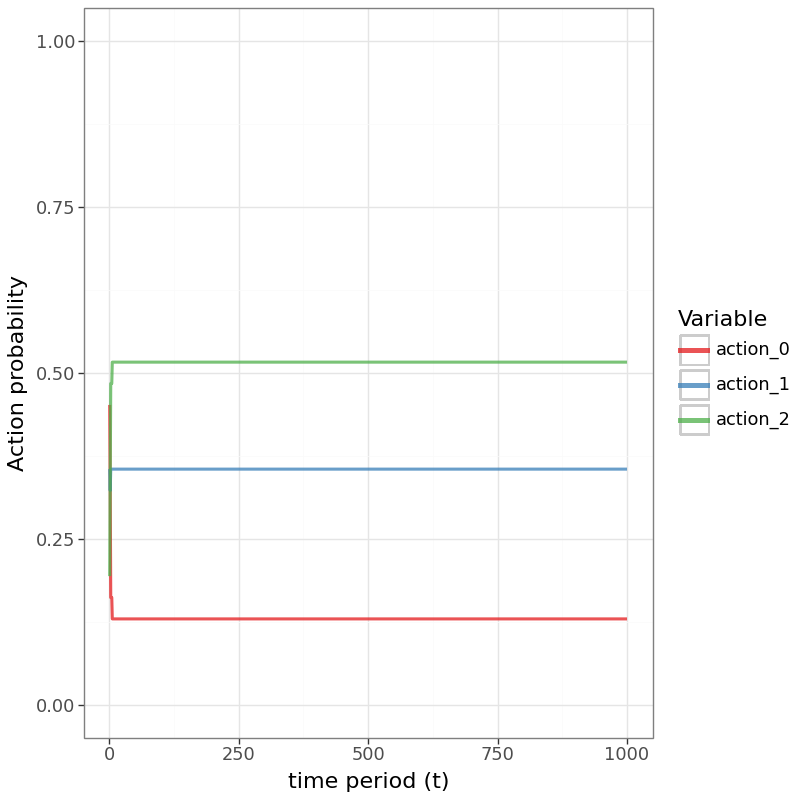

In [38]:
#@title Action selections for the greedy agent
from IPython import display
display.Image('/tmp/finite_simple_greedy_action.png')

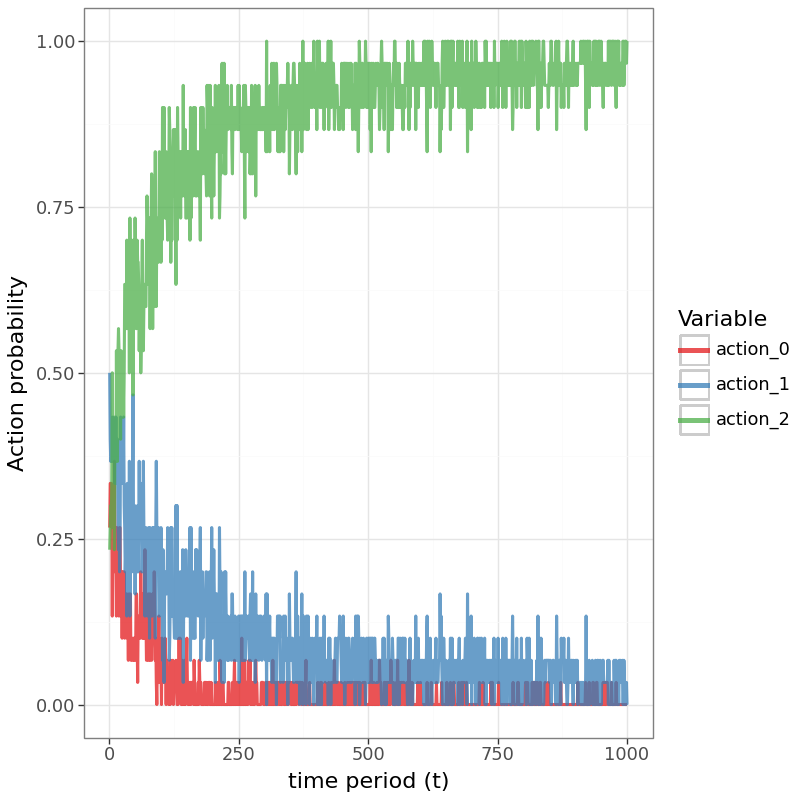

In [39]:
#@title Action selection for the TS agent
display.Image('/tmp/finite_simple_ts_action.png')

Note that these results do not *exactly* reproduce the paper due to the smaller number of seeds (for speed).

## Understanding the underlying experiment code

This section runs through the `local_runner.py` and shows how the underlying code is used.

Agent settings are defined in a `config` file, and then the "runner" loops through the different agents and evaluation

In [ ]:
#@title Imports (double-click to show/hide)
import importlib
import os
import sys
from base import config_lib
import numpy as np
import pandas as pd
import plotnine as gg


The list of experiment configs in the paper is given:

```
['finite_arm.config_simple', 'finite_arm.config_simple_rand', 'finite_arm.config_simple_sanity', 'finite_arm.config_misspecified', 'finite_arm.config_drift', 'cascading.config_cascading', 'ensemble_nn.config_nn', 'graph.config_indep', 'graph.config_indep_binary', 'graph.config_correlated', 'graph.config_correlated_sanity']
```

You can explore each setting in the relevant file of source code.

In [ ]:
#@title Set these variables to run from pre-populated config
CONFIG_PATH = 'finite_arm.config_simple' #@param
N_JOBS = 100 #@param

In [ ]:
#@title Pulling in that config file and running these agents
# Running from a local config file
sys.path.append(os.getcwd())

# Loading in the experiment config file
config_module = importlib.import_module(CONFIG_PATH)
config = config_module.get_config()

results = []
for job_id in range(N_JOBS):
  # Running the experiment.
  job_config = config_lib.get_job_config(config, job_id)
  experiment = job_config['experiment']
  experiment.run_experiment()
  results.append(experiment.results)


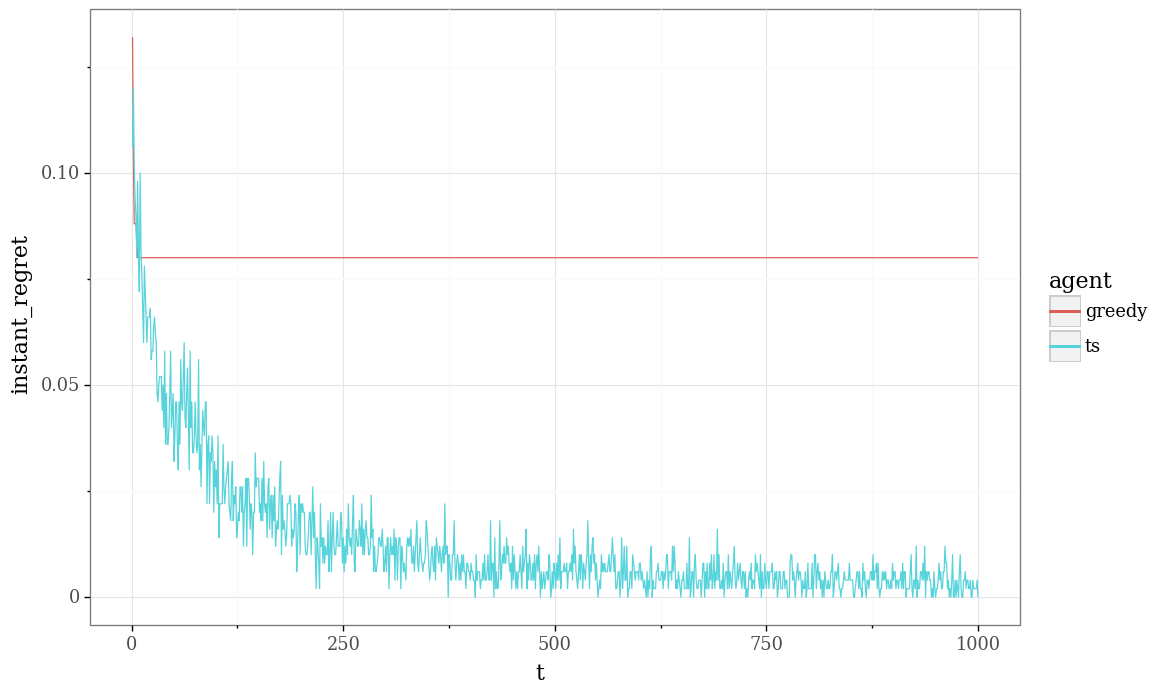

<ggplot: (8749007193769)>


In [ ]:
#@title Plotting and analysis (uses plotnine by default)

# Collating data from experiments results with Pandas
params_df = config_lib.get_params_df(config)
df = pd.merge(pd.concat(results), params_df, on='unique_id')
plt_df = (df.groupby(['agent', 't'])
          .agg({'instant_regret': np.mean})
          .reset_index())

# Set up a simple plot
gg.theme_set(gg.theme_bw(base_size=16, base_family='serif'))
gg.theme_update(figure_size=(12, 8))

p = (gg.ggplot(plt_df)
     + gg.aes('t', 'instant_regret', colour='agent')
     + gg.geom_line())
print(p)

Code for analysing and plotting agents is given in `base/plot.py` and if you use `reproduce_figures.py` will be called automatically.

## Running agents and environments without a config


Our code is meant to be as simple as possible, optimizing for ease of use rather than speed.

We break the experiments/algorithms into three key parts:

- `agent`: handles learning + action selection of a bandit algorithm.
- `environment`: evaluates rewards/outcomes from an action.
- `experiment`: contains agent, environment and seed.

In [ ]:
#@title Running a very simple agent on a finite armed bandit
from base.experiment import BaseExperiment
from finite_arm.agent_finite import FiniteBernoulliBanditTS
from finite_arm.env_finite import FiniteArmedBernoulliBandit

probs = [0.7, 0.8, 0.9]  #@param
n_steps = 1000  #@param
seed = 0  #@param

agent = FiniteBernoulliBanditTS(n_arm=len(probs))
env = FiniteArmedBernoulliBandit(probs)
experiment = BaseExperiment(
    agent, env, n_steps=n_steps, seed=seed, unique_id='example')

experiment.run_experiment()


   t  instant_regret  cum_regret  action unique_id
0  1             0.2         0.2       0   example
1  2             0.1         0.3       1   example
2  3             0.2         0.5       0   example
3  4             0.2         0.7       0   example
4  5             0.2         0.9       0   example


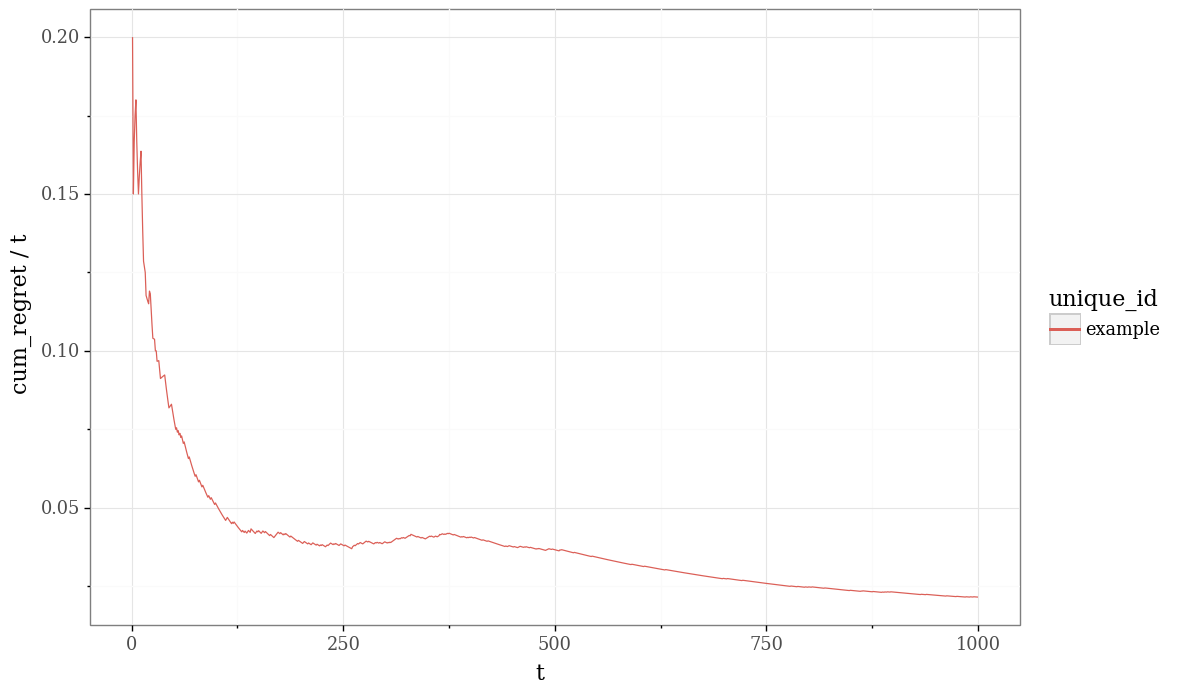

<ggplot: (8748996455358)>


In [ ]:
#@title Simple display / plot of results

print(experiment.results.head())

p = (gg.ggplot(experiment.results)
     + gg.aes(x='t', y='cum_regret / t', colour='unique_id')
     + gg.geom_line())
print(p)
